In [2]:
import drdf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def load_drdf(fname):
  reader = drdf.DRDF()
  reader.read(fname)
  events = []
  for run in reader.runs:
    for event in reader.runs[run]:
      hits_map = dict()
      for cam, img in reader.runs[run][event].items():
        amplitude = img.pixels[:, :, 0] 
        time = img.pixels[:, :, 1]
        hits_map[cam] = amplitude
      events.append((event, hits_map))
  return events

In [4]:
file_drdf_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last1/response.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last2/response.drdf"]
file_root_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last1/sensors.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last2/sensors.root"]

In [5]:
def CamList(fname):
    cam_list = []
    file = load_drdf(fname)
    for cam in file[0][1]:
        cam_list.append(cam)
    return cam_list

In [6]:
#creo una matrice 1000 righe x 54 colonne. ogni elemento è una camera 31x31
def AllImages(fname): 
    all_images_list = []
    cam_list = CamList(fname)
    file = load_drdf(fname)
    for i in range(len(file)):
        ph_matrix = []
        for cam in cam_list:
            ph_matrix.append(file[i][1][cam])
        all_images_list.append(ph_matrix)
    all_images = np.array(all_images_list)
    return all_images

In [7]:
def DimensionsData(fname):
    all_images = AllImages(fname)
    cam_list = CamList(fname)
    nr_events = len(all_images)
    nr_pixels = len(all_images[0][0])
    nr_cams = len(cam_list)
    nr_tot_events = nr_cams*nr_events
    nr_pixels_1_ev = nr_pixels*nr_pixels*nr_cams
    return nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev

In [8]:
#creo una matrice di 1000 righe e 51894 colonne. Così per ogni evento, la riga corrispondente presenta tutti i pixel di tutte le camere
def PixelsAllCamsPerEvents(fname):
    all_images = AllImages(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    pixels_to_scale = []
    for images_all_cams_per_ev in all_images: 
        pixels_all_cams_per_ev = images_all_cams_per_ev.flatten()
        pixels_to_scale.append(pixels_all_cams_per_ev)
    pixels_to_scale = np.asarray(pixels_to_scale)
    pixels_to_scale_matrix = pixels_to_scale.reshape(nr_events,nr_pixels_1_ev,1)
    return pixels_to_scale_matrix

In [9]:
def PlotCamsImages(fname):
    all_images = AllImages(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    for i in range(len(all_images)):
        #for cam in cam_list:
        for j in range(len(all_images[i])):
            plt.imshow(all_images[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()
            break
        break

#PlotCamsImages()

SCALING DATA

In [10]:
#non lo uso
from sklearn.preprocessing import RobustScaler

#applico lo scaling su vettori colonne che sono le camere 31x31 appiattite
def ScalingData(fname):
    pixels_to_scale_matrix = PixelsAllCamsPerEvents(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    photons_scaled_all_ev = []
    for pixels in pixels_to_scale_matrix:
        transformer = RobustScaler().fit(pixels)
        photons_scaled_in_cam = transformer.transform(pixels)
        photons_scaled_all_ev.append(photons_scaled_in_cam)
    photons_scaled_all_ev_matrix = np.asarray(photons_scaled_all_ev)
    all_images_scaled = photons_scaled_all_ev_matrix.reshape(nr_events,nr_cams,nr_pixels,nr_pixels)
    return all_images_scaled

In [11]:
#ora ho una matrice 1000righex54colonne dove un elemento è una matrice 31x31. Per essere consistente con i dati di root la voglio trasformare in un array di 54000 elementi
def Flattening(fname):
    all_images_scaled = ScalingData(fname)
    all_images_scaled_1d = []
    for sublist in all_images_scaled:
        all_images_scaled_1d.extend(sublist)
    return all_images_scaled_1d

In [12]:
def Reshaping(fname):
    all_images_scaled_1d_reshaped = []
    all_images = AllImages(fname)
    all_images_scaled_1d = Flattening(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    for data in all_images_scaled_1d:
        data_new = data.reshape(nr_pixels,nr_pixels,1)
        all_images_scaled_1d_reshaped.append(data_new)
    return all_images_scaled_1d_reshaped

In [13]:
def PlotCamsImages(fname):
    all_images_scaled = ScalingData(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    for i in range(len(all_images_scaled)):
        for j in range(len(all_images_scaled[i])):
            plt.imshow(all_images_scaled[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()
            break
        break

In [14]:
def PreprocessWithScaling(fname):
    return Reshaping(fname)

In [15]:
def PreprocessNotScaled(fname):
    matrix = AllImages(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    array = matrix.reshape(nr_events*nr_cams, nr_pixels, nr_pixels)
    return array

In [16]:
def SumPhotons(fname):
    tot_photons = []
    all_images = PreprocessNotScaled(fname)
    for j in all_images:
        sum_ph = np.sum(j)
        tot_photons.append(sum_ph)
    return tot_photons

ROOT

In [17]:
import ROOT as root

def OpenRootFile(rname,fname):
    #sensor1.root è il file; ogni camera è un TTree
    input_file = root.TFile.Open(rname, "READ")

    cam_list = CamList(fname)

    nr_photons_list_all_cams_list = []
    for cam in cam_list:
        nr_photons_list = []
        tree = input_file.Get(cam)
        entries = tree.GetEntries()
        for i in range(entries):
            n = tree.GetEntry(i)
            inner_photons = tree.innerPhotons
            nr_photons_list.append(inner_photons)
        nr_photons_list_all_cams_list.append(nr_photons_list)
        nr_photons_list_all_cams_tr = np.array(nr_photons_list_all_cams_list)#ho creato una matrice 1000 colonne (nr eventi) x 54 righe (nr camere). I numeri che vediamo sono i numeri di fotoni che arrivano alla camera
        nr_photons_list_all_cams = nr_photons_list_all_cams_tr.transpose()
    return nr_photons_list_all_cams

Welcome to JupyROOT 6.28/06


In [18]:
def InitializeDatasetParameters():
    ratio_thr = 0.1
    sum_thr = 40
    return ratio_thr, sum_thr

ratio_thr, sum_thr = InitializeDatasetParameters()

In [19]:
def EventListNumber(fname):
    file = load_drdf(fname)
    ev_list = []
    for i in range(len(file)):
        ev_list.append(file[i][0])
    return ev_list

In [20]:
def column(matrix, i):
    column = [row[i] for row in matrix]
    return column

def RootDataDictionary(rname,fname):
    nr_photons_list_all_cams = OpenRootFile(rname, fname)
    cam_list = CamList(fname)
    ev_list = EventListNumber(fname)

    final_root_data = []
    for i in range(len(nr_photons_list_all_cams)):
        nr_photon_in_cam = []
        for j in range(len(nr_photons_list_all_cams[i])):
            nr_photon_in_cam.append(nr_photons_list_all_cams[i][j])
        dict_cam_ev = dict(zip(cam_list, nr_photon_in_cam))
        final_root_data.append((ev_list[i], dict_cam_ev))
    return final_root_data

In [21]:
def InnerPhotonsList(rname,fname):
    final_root_data = RootDataDictionary(rname, fname)
    inner_photons_list = []
    for i in range(len(final_root_data)):
        for cam in final_root_data[i][1].keys():
            inner_photons_list.append(final_root_data[i][1][cam])  
    inner_photons_list = np.asarray(inner_photons_list)
    return inner_photons_list

def CamStatesRootList(rname,fname):
    inner_photons_list = InnerPhotonsList(rname,fname)
    tot_photons = SumPhotons(fname)
    
    ev_cam_state = []
    for i in range(len(inner_photons_list)):
        np.seterr(divide='ignore', invalid='ignore')
        ratio = inner_photons_list[i]/tot_photons[i]
        if ratio >= 0.1:
            value = 0
        elif ratio < 0.1:
            value = 1
        ev_cam_state.append(value)
    return ev_cam_state

In [22]:
def RootPreprocessing(rname, fname):
    return CamStatesRootList(rname, fname)

CNN MODEL

In [23]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from sklearn.model_selection import train_test_split

In [24]:
def Cut(rname: list, fname: list):
    all_images = np.concatenate([PreprocessNotScaled(f) for f in fname]) 
    root_images = np.concatenate([RootPreprocessing(rname[i],fname[i]) for i in range(len(fname))]) 
    all_images_scaled = np.concatenate([PreprocessWithScaling(f) for f in fname])

    index_to_cut = []
    i = 0
    for image in all_images:
        if np.sum(image)<40:
            index_to_cut.append(i)
        i += 1
    return index_to_cut, all_images, root_images, all_images_scaled

In [25]:
def DatasetCut(rname: list, fname: list):
    index_to_cut, all_images, root_images, all_images_scaled = Cut(rname, fname)
    all_images_list = list(all_images)
    root_images_list = list(root_images)
    all_images_scaled_list = list(all_images_scaled)
    
    for i in sorted(index_to_cut, reverse=True):
        del all_images_list[i], root_images_list[i], all_images_scaled_list[i]

    data_cut = np.array(all_images_list)
    root_cut = np.array(root_images_list)
    data_scaled_cut = np.array(all_images_scaled_list)

    data_cut = data_cut.reshape(data_cut.shape[0],32,32,1)
    data_scaled_cut = data_scaled_cut.reshape(data_scaled_cut.shape[0],32,32,1)

    return data_cut, root_cut, data_scaled_cut

In [26]:
data_cut, root_cut, data_scaled_cut = DatasetCut(file_root_list, file_drdf_list)

In [27]:
def PrepareData(rname: list, fname: list):
    data_cut, root_cut, data_scaled_cut = DatasetCut(rname, fname)
    t_ds, val_ds, t_labels, val_labels = train_test_split(data_scaled_cut, root_cut, train_size=0.99, random_state=42)
    train_ds, test_ds, train_labels, test_labels = train_test_split(t_ds, t_labels, train_size=0.9, random_state=42)

    train_ds = np.asarray(train_ds)
    val_ds = np.asarray(val_ds)
    test_ds = np.asarray(test_ds)

    train_ds = train_ds.reshape(train_ds.shape[0], 32, 32,1)
    val_ds = val_ds.reshape(val_ds.shape[0], 32, 32, 1)
    test_ds = test_ds.reshape(test_ds.shape[0],32,32,1)

    return train_ds, val_ds, test_ds, train_labels, val_labels, test_labels

In [28]:
def FindBlindEvents(rarray,farray):
    n = 0
    nr_blind_events = []
    blind_events = []
    for i in rarray:
        if i == 0:
            nr_blind_events.append(n)
        n+=1
    for i in nr_blind_events:
        blind_events.append(farray[i])
    return nr_blind_events, blind_events

In [29]:
def Augmentation(rarray, farray):
    input_shape = [32,32,32,1]
    data_augmentation = keras.Sequential()
    data_augmentation.add(layers.RandomFlip("horizontal", input_shape=input_shape[1:]))
    data_augmentation.add(layers.RandomFlip("vertical", input_shape=input_shape[1:]))
    data_augmentation.add(layers.RandomRotation(0.2))
    #data_augmentation.add(layers.RandomTranslation(0.2,0.2))
    #data_augmentation.add(layers.RandomZoom(0.8))
    
    nr_blind_events1, blind_events1 = FindBlindEvents(rarray,farray)

    augmented_ds = []
    for blind_im in blind_events1:
        for i in range(150):
            augmented_image = data_augmentation(blind_im)
            augmented_image_sq = np.squeeze(augmented_image, axis=3)
            augmented_ds.append(augmented_image_sq)
    augmented_ds = np.asarray(augmented_ds)

    augmented_labels = len(augmented_ds)*[0]
    return augmented_ds, augmented_labels

In [30]:
def DatasetwithAugmentation(rname: list, fname: list, rarray, farray):
    train_ds, val_ds, test_ds,train_labels, val_labels,test_labels = PrepareData(rname, fname)
    augmented_ds, augmented_labels = Augmentation(rarray, farray)
    train_ds_aug = np.concatenate((train_ds,augmented_ds),axis=0)
    train_labels_aug = np.concatenate((train_labels,augmented_labels),axis=0)
    return train_ds_aug, train_labels_aug

In [31]:
def DatasetWeights(rarray, farray):
    nr_blind_events1, blind_events1 = FindBlindEvents(rarray, farray)

    augmented_ds, augmented_labels = Augmentation(rarray, farray)
    
    nr_blind_ev = len(nr_blind_events1) + len(augmented_ds)
    nr_tot_ev = len(rarray) + len(augmented_ds)
    nr_not_blind_ev = nr_tot_ev - nr_blind_ev

    initial_bias = np.log(nr_blind_ev/nr_not_blind_ev)

    weights_0 = (1/nr_blind_ev)*(nr_tot_ev/2)
    weights_1 = (1/nr_not_blind_ev)*(nr_tot_ev/2)
    weights_classes = {0: weights_0, 1: weights_1}

    percentage = {0: nr_blind_ev/nr_tot_ev, 1: nr_not_blind_ev/nr_tot_ev}

    return initial_bias, weights_classes, percentage

In [32]:
train_ds, val_ds, test_ds,train_labels, val_labels,test_labels = PrepareData(file_root_list, file_drdf_list)

In [33]:
train_ds_aug, train_labels_aug = DatasetwithAugmentation(file_root_list, file_drdf_list, root_cut, data_scaled_cut)

In [34]:
initial_bias, weights_classes, percentage = DatasetWeights(root_cut, data_scaled_cut)
epochs = 10

In [35]:
percentage

{0: 0.3492838169316608, 1: 0.6507161830683392}

In [36]:
weights_classes

{0: 1.4315006185867114, 1: 0.7683841481278931}

In [37]:
def Training(rname: list, fname: list): 
    #initial_bias, weights_classes = DatasetWeights(rname,fname)
    input_shape = [32,32,32,1]
    output_bias = keras.initializers.Constant(initial_bias)

    model = models.Sequential([
    # Flatten layer per trasformare l'immagine in un vettore
    layers.Conv2D(32, (3,3), activation='relu',input_shape = input_shape[1:]),
    layers.MaxPooling2D((2,2)),
    # layers.Conv2D(32, (3,3), activation='relu'),#input_shape = input_shape[1:]),
    # layers.MaxPooling2D((2,2)),
    layers.Flatten(),#(input_shape = input_shape[1:]),
    
    # Dense layers per la parte completamente connessa della rete
    layers.Dense(128, activation='relu', bias_initializer=output_bias),
    layers.Dense(64, activation='relu'),
    layers.Dense(32,activation='relu'),
    
    # Output layer con un neurone e attivazione sigmoide per classificazione binaria
    layers.Dense(1, activation='sigmoid')
])

    model.compile(optimizer='Adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])#,'precision','recall'])
    model.summary()
    return model


In [38]:
model = Training(file_root_list, file_drdf_list)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 128)               921728    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                      

In [39]:
#callbacks = [keras.callbacks.ModelCheckpoint("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_new.keras")]
history = model.fit(train_ds_aug, train_labels_aug, validation_data= (val_ds, val_labels), epochs=epochs, batch_size=32, class_weight=weights_classes)

Epoch 1/10
4568/4568 [==============================] - 35s 8ms/step - loss: 0.0513 - accuracy: 0.9889 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 2/10
4568/4568 [==============================] - 34s 7ms/step - loss: 0.0213 - accuracy: 0.9972 - val_loss: 0.0141 - val_accuracy: 0.9951
Epoch 3/10
4568/4568 [==============================] - 34s 7ms/step - loss: 0.0144 - accuracy: 0.9979 - val_loss: 0.0065 - val_accuracy: 0.9971
Epoch 4/10
4568/4568 [==============================] - 35s 8ms/step - loss: 0.0143 - accuracy: 0.9980 - val_loss: 0.0056 - val_accuracy: 0.9990
Epoch 5/10
4568/4568 [==============================] - 35s 8ms/step - loss: 0.0111 - accuracy: 0.9981 - val_loss: 0.0068 - val_accuracy: 0.9990
Epoch 6/10
4568/4568 [==============================] - 34s 7ms/step - loss: 0.0083 - accuracy: 0.9990 - val_loss: 0.0081 - val_accuracy: 0.9990
Epoch 7/10
4568/4568 [==============================] - 35s 8ms/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0083 - val_ac

In [40]:
saved_model = model.save("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_aug2_last.keras")

In [41]:
predictions_val = model.predict(val_ds)
predictions = np.squeeze(predictions_val)

i = 0
predictions_val_approx = []
for value in predictions:
    value_approx = int(round(value,0))
    predictions_val_approx.append(value_approx)

predictions_val_approx = np.asarray(predictions_val_approx)

33/33 [==============================] - 0s 2ms/step


[[   2    0]
 [   0 1026]]


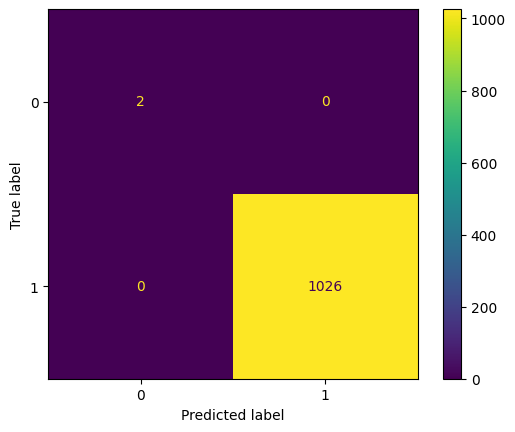

In [42]:
from sklearn import metrics

cm = metrics.confusion_matrix(val_labels, predictions_val_approx)
print(cm)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

In [43]:
test_ds.shape

(10174, 32, 32, 1)

In [44]:
old_model = models.load_model("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/good_models/cams_model_bestever_newdata.keras")

AttributeError: 'Adam' object has no attribute 'build'

In [ ]:
test_ds = test_ds.reshape(test_ds.shape[0], 32, 32, 1)
predictions_test = model.predict(test_ds)
predictions = np.squeeze(predictions_test)

i = 0
predictions_test_approx = []
for value in predictions:
    value_approx = int(round(value,0))
    predictions_test_approx.append(value_approx)

predictions_test_approx = np.asarray(predictions_test_approx)

318/318 [==============================] - 1s 2ms/step


[[   18    15]
 [   12 10129]]


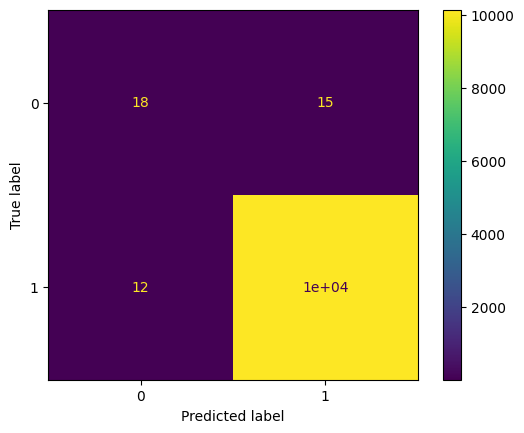

In [ ]:
cm = metrics.confusion_matrix(test_labels, predictions_test_approx)
print(cm)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

In [ ]:
F1 = metrics.f1_score(test_labels, predictions_test_approx, average = 'binary')
F1

0.9986689672171556